## Static Bayesian Networks per period

This notebook allows to fit static BN for the specified sector in a period identified by min and max dates specified in input.

This notebook is made of the following main steps:

* Fit bayesian network using the library pgmpy. Structure learning is done on multiple boostrapped datasets and multi-core is exploited to parallelize the computations

* Perform parameter learning and make inference to determine links' strengths. Link strength is defined as P[ sink=1 | source=1 ] (probability of a jump in the sink node given a jump in the source node)

* Estimate partial correlations between linked issuers via tigramite

* Plot the resulting graphs

In [1]:
import pandas as pd
import numpy as np
import os
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator, TreeSearch, MmhcEstimator
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import time
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from scipy.optimize import minimize_scalar
from statsmodels.distributions.empirical_distribution import ECDF
from pgmpy.models import BayesianNetwork
import time
from joblib import Parallel, delayed
from pgmpy.inference import VariableElimination
import sys
sys.path.append('../Modules')
from tigramite_utils import *
from utils_bayesian_networks import *

/anaconda/envs/work_env/lib/python3.9/site-packages/tigramite/independence_tests/gpdc.py:27: UserWarning: [Errno 2] No such file or directory: '/anaconda/envs/work_env/lib/python3.9/site-packages/tigramite/independence_tests/../../versions.py'
  warnings.warn(str(e))
/anaconda/envs/work_env/lib/python3.9/site-packages/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: No module named 'gpytorch'
  warnings.warn(str(e))


In [2]:
# Specify sector, min date and max date
sector = 'Energy'
min_date = '2015-09-30'
max_date = '2019-01-01'

compute_partial_correlation = False

In [3]:
df_all, df_all_lookup, _, _, _ =\
    import_data_clustering_issuer_rf(issuer_curves_file_name='../Data/Basedati3_spread.csv',
                                    fx_rf_file_name='../Data/Observations - UniverseFX.csv',
                                    local_rf_file_name='../Data/Observations - UniverseLOCAL.csv',sep_issuer_curves_file=';')
df_all['CurveID_Short'] = df_all['CurveID'].apply(lambda x  : str(x).split('-')[0] + '_' + str(x).split('-')[1])

dict_mapping_names = df_all[['CurveID_Short', 'Name']].drop_duplicates().set_index('CurveID_Short').to_dict()['Name']

df_spread = remove_series_mostly_na(df_all_lookup, 0.9)

# Select only curves from a specified sector
curves_sector = df_all[['CurveID', 'MS_Sector']].loc[lambda x: x['CurveID'].isin(list(df_spread.columns))].\
    drop_duplicates().\
    loc[lambda x: x['MS_Sector'] == sector]['CurveID'].unique()
print('Number of curves in sector ' + sector + ': ' + str(len(curves_sector)))

df_sector_spread = df_spread.loc[:,curves_sector]
df_sector_spread.index = pd.to_datetime(df_spread.index)
df_sector_spread.columns = [i.split('-')[0] + '_' + i.split('-')[1] for i in list(df_sector_spread.columns)]
df_sector_spread.shape

Maximum Timestamp of available data point 2015-10-01 00:00:00
Minimum Timestamp of not null data point cross time series 2022-02-04 00:00:00
Number of curves in sector Energy: 34


(1657, 34)

In [4]:
# Define discrete status for the specified sector in the 3 periods and on the whole time horizon
define_discrete_states_based_on_volatility_jumps(df_sector_spread, roll_window = 3, final_dates=['2019-01-01', '2020-10-01'],
                                                 output_path='../Data/discrete_status_bn/', type_name=sector)

Min date: 2015-09-30
Max date: 2019-01-01


Min date: 2019-01-01
Max date: 2020-10-01


Min date: 2020-10-01
Max date: 2022-02-04




In [5]:
# Read discrete data for the specified status (period)

input_data = pd.read_csv('../Data/discrete_status_bn/discrete_data_' + sector + '_' +
                         min_date + '_' + max_date + '.csv', sep=',')

for i in input_data:
    input_data[i] = input_data[i].astype('category')

input_data

CNOOC_113994 CNPCCH_2458 COP_20461 CVECN_146668 CVX_18346 GAZPRU_23201  \
0            0.0         0.5       1.0          0.0       0.0          0.0   
1            0.0         1.0       0.0          0.0       0.0          0.0   
2            0.5         0.0       0.5          0.0       0.0          0.0   
3            0.0         0.0       0.0          0.0       0.0          0.0   
4            0.5         0.0       0.5          0.0       0.0          0.0   
..           ...         ...       ...          ...       ...          ...   
840          0.5         0.0       0.5          0.5       0.0          0.5   
841          1.0         0.0       0.5          1.0       0.0          1.0   
842          0.0         0.0       1.0          0.0       0.0          0.0   
843          0.0         0.0       0.0          0.0       0.0          0.0   
844          0.0         0.0       0.0          0.0       0.0          0.0   

    HAL_4917 HES_14761 KMP_6499 KOROIL_150832  ... ENI_17347 KMI_157215  \
0        0.0       0.0      0.5           0.5  ...       0.0        0.5   
1        0.5       0.0      1.0           1.0  ...       0.0        1.0   
2        0.5       0.0      0.0           0.0  ...       0.0        0.0   
3        0.0       0.0      0.0           0.0  ...       0.0        0.0   
4        1.0       0.0      0.0           0.0  ...       0.0        0.0   
..       ...       ...      ...           ...  ...       ...        ...   
840      0.0       0.5      0.0           0.5  ...       0.5        1.0   
841      0.0       1.0      0.0           0.5  ...       0.5        0.0   
842      0.0       0.0      0.0           0.5  ...       0.5        0.0   
843      0.0       0.0      0.0           1.0  ...       1.0        0.0   
844      0.0       0.0      0.0           0.0  ...       0.0        0.0   

    NESVFH_25182 OMV_22332 PEMEX_9082 RDSALN_17350 REPSM_15934 STOIL_11797  \
0            0.0       0.0        0.5          0.0         0.0         0.0   
1            0.0       0.0        1.0          0.0         0.0         0.0   
2            0.5       0.0        0.5          0.0         0.5         0.0   
3            0.0       0.0        0.0          0.0         0.0         0.0   
4            0.5       0.5        1.0          0.0         0.5         0.5   
..           ...       ...        ...          ...         ...         ...   
840          0.5       0.5        0.0          0.5         0.5         0.0   
841          0.5       0.5        0.0          0.5         0.5         0.0   
842          1.0       1.0        0.0          1.0         1.0         0.0   
843          0.0       0.0        0.0          0.0         0.0         0.0   
844          0.0       0.0        0.0          0.0         0.0         0.0   

    SXL_18978 TOTAL_24978  
0         0.0         0.0  
1         0.0         0.0  
2         0.0         0.0  
3         0.0         0.0  
4         0.0         0.0  
..        ...         ...  
840       0.0         0.5  
841       0.0         0.5  
842       0.0         1.0  
843       0.0         0.0  
844       0.0         0.0  

[845 rows x 34 columns]

### BAYESIAN NETWORK LEARNING


1. Create all bootstrapped datasets


2. Create a df with columns from-to-strength-direction with all possible pairs of directed arcs


3. For each bootstrapped dataset:
   * Run HillClimbSearch.estimate to estimate the model
   * Update the number of times that each arc is estimated (taking direction into account) (columns "strength" and "direction" in the df from point 2)
   
  
4. Define "freq_direction" as frequency of each direction per each arc (e.g., A->B estimated 10 times, B->A estimated 4 times, then freq_direction(A->B) = 10/14 and freq_direction(B->A) = 4/14)


5. Define "freq_strength" as the number of times an arc (undirected) has been detected divided by the total number of experiments


6. Model Averaging:
   * Compute threshold for freq_strength (function used in the R library bnlearn)
   * Apply filter on arcs using the threshold
   
   
7. Parameter Learning


8. Inference to determine link strength

In [6]:
# STEP 1: Bootstrapped datasets creation

seed = 0
num_bootstrap_dataset = 10
bootstrap_datasets = []
np.random.seed(seed)

for i in range(num_bootstrap_dataset):
    bootstrap_datasets.append(input_data.sample(frac=1, replace=True).reset_index(drop=True))

### In case you want to use a previously saved model, go to [this cell](#saved_model_cell)

In [8]:
# # #### NO PARALLELISM

# results_bootstrap = pd.DataFrame(list(input_data.columns), columns=['from']).\
#     merge(pd.DataFrame(list(input_data.columns), columns=['to']), how='cross').\
#     loc[lambda x: x['from'] != x['to']]
# results_bootstrap[['strength', 'direction']] = [0, 0]

# for i in range(len(bootstrap_datasets)):
#     df = bootstrap_datasets[i]
#     es = HillClimbSearch(df)
#     best_model = es.estimate(scoring_method=BicScore(df))

#     curr_results = pd.DataFrame(list(best_model.edges()), columns=['from', 'to']).assign(directed=True)
#     curr_results = pd.concat([curr_results, curr_results[['to', 'from']].rename(columns={'from': 'to', 'to': 'from'}).\
#                               assign(directed=False)])

#     results_bootstrap = results_bootstrap.merge(curr_results, how='left').\
#         assign(strength = lambda x: np.where(~x['directed'].isnull(), x['strength']+1, x['strength']),
#                direction = lambda x: np.where((x['directed']) & (~x['directed'].isnull()), x['direction']+1, x['direction'])).\
#         drop(columns=['directed'])
    


In [9]:
start = time.time()

num_cores = 4
obs_per_core = int(len(bootstrap_datasets)/num_cores)
boot_df_batch = []
for i in range(num_cores):
    boot_df_batch.append(bootstrap_datasets[(obs_per_core*i):(obs_per_core*(i+1))])

In [10]:
# STEP 2-3: run estimate of dag on each bootstrapped dataset and collect results

start = time.time()

num_cores = 4
obs_per_core = int(len(bootstrap_datasets)/num_cores)
boot_df_batch = []
for i in range(num_cores):
    boot_df_batch.append(bootstrap_datasets[(obs_per_core*i):(obs_per_core*(i+1))])

def estimate_model(bootstrap_datasets, input_data):
    results_bootstrap = pd.DataFrame(list(input_data.columns), columns=['from']).\
        merge(pd.DataFrame(list(input_data.columns), columns=['to']), how='cross').\
        loc[lambda x: x['from'] != x['to']]
    results_bootstrap[['strength', 'direction']] = [0, 0]
    
    for i in range(len(bootstrap_datasets)):
        df = bootstrap_datasets[i]
        es = HillClimbSearch(df)
        best_model = es.estimate(scoring_method=BicScore(df))

        curr_results = pd.DataFrame(list(best_model.edges()), columns=['from', 'to']).assign(directed=True)
        curr_results = pd.concat([curr_results, curr_results[['to', 'from']].rename(columns={'from': 'to', 'to': 'from'}).\
                                  assign(directed=False)])

        results_bootstrap = results_bootstrap.merge(curr_results, how='left').\
            assign(strength = lambda x: np.where(~x['directed'].isnull(), x['strength']+1, x['strength']),
                   direction = lambda x: np.where((x['directed']) & (~x['directed'].isnull()), x['direction']+1, x['direction'])).\
            drop(columns=['directed'])
    
    return results_bootstrap

results = Parallel(n_jobs=num_cores)(delayed(estimate_model)(list_df, input_data) for list_df in boot_df_batch)

# Merge results
results_bootstrap = results[0]
for i in range(1, len(results)):
    results_bootstrap = results_bootstrap.\
        merge(results[i], how='inner', on=['from', 'to']).\
        assign(strength=lambda x: x['strength_x'] + x['strength_y'],
               direction=lambda x: x['direction_x'] + x['direction_y']).\
        drop(columns=['strength_x', 'strength_y', 'direction_x', 'direction_y'])
    
print('Elapsed time: ' + str(time.time() - start))

  0%|          | 46/1000000 [00:14<57:36:18,  4.82it/s]

Elapsed time: 31.35096764564514


  0%|          | 46/1000000 [00:14<86:12:02,  3.22it/s]


In [11]:
# STEP 4-5: compute frequencies of appearance of arcs and directions

results_bootstrap['freq_strength'] = results_bootstrap['strength']/num_bootstrap_dataset
results_bootstrap['freq_direction'] = results_bootstrap['direction']/results_bootstrap['strength']

In [12]:
# STEP 6: model averaging

e = ECDF(results_bootstrap['freq_strength'])
e(results_bootstrap['freq_strength'].sort_values())

u = results_bootstrap['freq_strength'].sort_values()
    
norm = lambda x: sum(np.diff(np.unique([0, *u, 1])) * abs(e(np.unique([0, *u[u < 1]])) - x))

p0 = minimize_scalar(norm, method='bounded', bounds=(0,1)).x

threshold = np.quantile(results_bootstrap['freq_strength'], p0)

significant_arcs = results_bootstrap.\
    loc[lambda x: (x['freq_strength'] >= threshold) & (x['freq_direction'] > 0.5)]

model_graph = nx.Graph()
model_graph.add_nodes_from(list(input_data.columns))
model_graph = model_graph.to_directed()
model_graph.add_edges_from(list(significant_arcs[['from', 'to']].to_records(index=False)))

if not nx.is_directed_acyclic_graph(model_graph):
    print('Making graph acyclic')
    for edge in list(model_graph.edges()):
        source = edge[0]
        sink = edge[1]
        new_graph = model_graph.copy()
        new_graph.remove_edge(source, sink)
        if nx.is_directed_acyclic_graph(new_graph):
            break
    model_graph = new_graph.copy()

plt.rcParams['figure.figsize'] = (18,10)
pos = graphviz_layout(model_graph, prog="dot")
nx.draw(model_graph, pos, with_labels=True, node_size = 3000, node_color='yellow')
plt.show()

Making graph acyclic


In [13]:
nx.is_directed_acyclic_graph(model_graph)

True

In [14]:
# Remove arcs which were removed to avoid cycles

new_arcs = pd.DataFrame(columns=significant_arcs.columns)
list_edges = list(model_graph.edges())
for i in range(len(significant_arcs)):
    source = significant_arcs.iloc[i, :]['from']
    sink = significant_arcs.iloc[i, :]['to']
    
    if (source, sink) in list_edges:
      new_arcs = pd.concat([new_arcs, pd.DataFrame(significant_arcs.iloc[i, :]).T], ignore_index=True)
    
significant_arcs = new_arcs.copy()

In [26]:
# Save results on all bootstrapped datasets and .csv file with all arcs
results_bootstrap.to_csv('../Output/5.1._BN_Results/results_pgmpy_plus_tigramite_2000_simulations_BKP_MODELS/' + sector + '_'
                         + min_date + '_' + max_date + '_res_boot.csv', sep=';', index=False)

In [15]:
# STEP 7: Parameter Learning

bn_model = BayesianNetwork(model_graph)
bn_model.fit(input_data, estimator=MaximumLikelihoodEstimator)

for cpd in bn_model.get_cpds():
    print(cpd)
    
# bn_model.cpds is a list giving the conditional probabilities for each node of the network
# bn_model.cpds allows to understand each element of the list which node refers to
# e.g., bn_model.cpds[11] refers to conditional probabilities of STOIL given its parents ENI and TOTAL
# EXAMPLE: P(STOIL=0.5 | ENI=1, TOTAL=0)
# bn_model.cpds[11].get_value(STOIL = 0.5, ENI=1, TOTAL=0)

+----------------+----------+
| ABT_23457(0.0) | 0.569231 |
+----------------+----------+
| ABT_23457(0.5) | 0.302959 |
+----------------+----------+
| ABT_23457(1.0) | 0.127811 |
+----------------+----------+
+-----------------+-----+--------------------+
| SGP_14641       | ... | SGP_14641(1.0)     |
+-----------------+-----+--------------------+
| AMGN_25256(0.0) | ... | 0.4827586206896552 |
+-----------------+-----+--------------------+
| AMGN_25256(0.5) | ... | 0.1724137931034483 |
+-----------------+-----+--------------------+
| AMGN_25256(1.0) | ... | 0.3448275862068966 |
+-----------------+-----+--------------------+
+----------------+-----+---------------------+
| UNH_24844      | ... | UNH_24844(1.0)      |
+----------------+-----+---------------------+
| ATH_21707(0.0) | ... | 0.4387755102040816  |
+----------------+-----+---------------------+
| ATH_21707(0.5) | ... | 0.22448979591836735 |
+----------------+-----+---------------------+
| ATH_21707(1.0) | ... | 0.33673469387

In [16]:
# STEP 8: Inference to determine link strength

model_infer = VariableElimination(bn_model)

link_strength = {}
for edge in bn_model.edges():
    q = model_infer.query(variables=[edge[1]], evidence={edge[0]: 1}, show_progress=False)
    link_strength[edge] = q.values[2]

In [26]:
# Save estimated model as .bif file

bn_model.save('../Output/5.1._BN_Results/results_pgmpy_plus_tigramite_2000_simulations_BKP_MODELS/' + sector + '_' 
              + min_date + '_' + max_date + '_model.bif')

<a id='saved_model_cell'></a>

### Run from the below cell onwards if you want to load a saved model

In [7]:
# # Use this cell if you want to read a model saved in previous executions

# from pgmpy.readwrite import BIFReader
# reader = BIFReader("../Output/5.1._BN_Results/results_pgmpy_plus_tigramite_2000_simulations_BKP_MODELS/" + sector + 
#                    "_" + min_date + '_' + max_date + "_model.bif")
# model_bn = reader.get_model()
# model_graph = nx.Graph()
# model_graph.add_nodes_from(list(input_data.columns))
# model_graph = model_graph.to_directed()
# model_graph.add_edges_from(list(model_bn.edges()))
# pos = graphviz_layout(model_graph, prog="dot")

# new_arcs = pd.DataFrame(columns=[0,1])
# list_edges = list(model_bn.edges())
# for i in range(len(list_edges)):
#     source = list_edges[i][0]
#     sink = list_edges[i][1]
#     new_arcs = pd.concat([new_arcs, pd.DataFrame([source, sink]).T], ignore_index=True)
    
# significant_arcs = new_arcs.copy()
# significant_arcs.columns = ['from', 'to']

# # Inference to determine link strength
# model_infer = VariableElimination(model_bn)

# link_strength = {}
# for edge in model_bn.edges():
#     q = model_infer.query(variables=[edge[1]], evidence={edge[0]: '1.0'}, show_progress=False)
#     link_strength[edge] = q.values[2]
    

## Tigramite to determine intensity of relations

In [8]:
# Read input data to compute partial correlations

df_all, df_all_lookup, _, _, _ =\
    import_data_clustering_issuer_rf(issuer_curves_file_name='Basedati3_spread.csv',
                                    fx_rf_file_name='../Data/Observations - UniverseFX.csv',
                                    local_rf_file_name='../Data/Observations - UniverseLOCAL.csv',sep_issuer_curves_file=';')
df_all['CurveID_Short'] = df_all['CurveID'].apply(lambda x  : str(x).split('-')[0] + '_' + str(x).split('-')[1])
df_complete = pd.read_csv('../Data/conditional_volatility_issuers_BaseDati3.csv', sep=';')
df_complete['Date'] = pd.to_datetime(df_complete['Date'])
df_complete = df_complete.set_index('Date', drop=True)

In [9]:
# Select only curves from a specified sector
curves_sector = df_all[['CurveID', 'MS_Sector']].loc[lambda x: x['CurveID'].isin(df_complete.columns)].\
    drop_duplicates().\
    loc[lambda x: x['MS_Sector'] == sector]['CurveID'].unique()
print('Number of curves in sector ' + sector + ': ' + str(len(curves_sector)))

df_sector = df_complete.loc[:,curves_sector]
df_sector.index = pd.to_datetime(df_complete.index)
df_sector.shape

Number of curves in sector Energy: 34


(1656, 34)

In [10]:
# Rename columns in order to have same names in model graph and df_sector.columns

dict_mapping_names_short_complete = df_all[['CurveID', 'CurveID_Short']].drop_duplicates().set_index('CurveID').to_dict()['CurveID_Short']
df_sector.columns = [dict_mapping_names_short_complete[i] for i in list(df_sector.columns)]

In [11]:
# Estimate partial correlation via tigramite for the different periods

if compute_partial_correlation:
    significant_arcs, dict_edge_labels, node_colors = \
        compute_partial_correlation_tigramite(df_sector, model_graph=model_graph, max_lag=10)
else:
    temp = pd.DataFrame(link_strength.items()).rename(columns={0: 'edge', 1: 'link_strength'})
    temp[['from', 'to']] = pd.DataFrame(temp['edge'].tolist(), index=temp.index)
    significant_arcs = temp[['from', 'to', 'link_strength']].rename(columns={'link_strength': 'value'})    

In [12]:
## Define and plot new graph with the structure discovered by the bayesian network algorithm and quantitative information
## determined by the conditional indipendence tests carried out via tigramite

plt.rcParams['figure.figsize'] = (18,10)

model_graph_final = nx.Graph()
model_graph_final.add_nodes_from(list(input_data.columns))
model_graph_final = model_graph.to_directed()
model_graph_final.add_weighted_edges_from(list(significant_arcs[['from', 'to', 'value']].to_records(index=False)))

weights = [model_graph_final[u][v]['weight'] for u,v in model_graph_final.edges()]

# Determine node color based on in/out degree:
# - Isolated nodes -> white
# - Nodes with out_degree>0 & in_degree=0 -> orange
# - Nodes with out_degree>0 & in_degree>0 -> yellow
# - Nodes with out_degree=0 & in_degree>0 -> grey
node_colors = ['white' for i in range(len(model_graph_final.nodes))]
for k in range(model_graph_final.number_of_nodes()):
    node = list(model_graph_final.nodes())[k]
    if model_graph_final.degree[node] != 0:
        if model_graph_final.in_degree[node] == 0:
            node_colors[k] = 'orange'
        elif model_graph_final.out_degree[node] == 0:
            node_colors[k] = 'grey'
        else:
            node_colors[k] = 'yellow'

# Modify positions of nodes so that isolated nodes are all located in a vertical line at the right of the chart
# and there is more space for the "connected part" of the graph
isolated_nodes = [i for i in dict(model_graph_final.degree()).keys() if dict(model_graph_final.degree())[i] == 0]
non_isolated_nodes = [i for i in list(model_graph_final.nodes()) if i not in isolated_nodes]

max_x_non_isolated = max([pos[i][0] for i in non_isolated_nodes])
if len([pos[i][0] for i in isolated_nodes if pos[i][0] > max_x_non_isolated]) > 0:
    fix_x = min([pos[i][0] for i in isolated_nodes if pos[i][0] > max_x_non_isolated]) + 100
    min_y = min([i[1] for i in pos.values()])
    max_y = max([i[1] for i in pos.values()])
    y_pos_isol_nodes = np.linspace(min_y, max_y, len(isolated_nodes))

    for k in range(len(isolated_nodes)):
        pos[isolated_nodes[k]] = (fix_x, y_pos_isol_nodes[k])

if compute_partial_correlation:
    nx.draw(model_graph_final, pos, with_labels=True,
            node_size = [1000+500*i for i in list(dict(model_graph_final.out_degree()).values())],
            font_color='black', font_size=8,
            edge_color=weights, edge_cmap=plt.cm.coolwarm, edge_vmin=-1, edge_vmax=1,
            node_color=node_colors, edgecolors='grey', cmap=plt.cm.Reds, vmin=0, vmax=1,
            labels={i: i.split('_')[0] for i in list(model_graph.nodes)})
    nx.draw_networkx_edge_labels(model_graph_final, pos, edge_labels=dict_edge_labels, rotate=False,
                                label_pos=0.5)

    edge_bar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=-1, vmax=1)),
                            fraction=0.05, shrink=0.2, orientation='vertical')
    edge_bar.ax.set_title('Cross correlation')

#     node_bar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(0,1)),
#                  fraction=0.05, shrink=0.2, orientation='vertical')
#     node_bar.ax.set_title('Auto correlation')

    plt.savefig('../Output/5.1._BN_Results/results_discrete_bn/' + sector + '_' + min_date + '_' + max_date + '.png')
    plt.show()


In [13]:
df_names_mapping = pd.DataFrame(dict_mapping_names.items(), columns=['label', 'name'])
df_names_mapping['label'] = df_names_mapping['label'].apply(lambda x: x.split('_')[0])
df_names_mapping

label                          name
0        AA    ALCOA NEDERLAND HOLDING BV
1      AARB                AAREAL BANK AG
2    ABBLTD                       ABB LTD
3       ABT           ABBOTT LABORATORIES
4       ABT  ABBOTT IRELAND FINANCING DAC
..      ...                           ...
749     WPC                  WP CAREY INC
750   WPPLN              WPP FINANCE 2010
751  ZFFNGR  ZF NORTH AMERICA CAPITAL INC
752     ZKB         ZUERCHER KANTONALBANK
753  ZURNVX                  CLOVERIE PLC

[754 rows x 2 columns]

In [14]:
# Create dictionary with edge colors based on link strength values

thr_strength_1 = 0.3
thr_strength_2 = 0.6
color_strength_1 = 'plum'
color_strength_2 = 'blue'
color_strength_3 = 'navy'

edge_color = {edge: color_strength_1 for edge in link_strength if link_strength[edge] <= thr_strength_1}
edge_color.update({edge: color_strength_2 for edge in link_strength
                    if link_strength[edge] > thr_strength_1 and link_strength[edge] <= thr_strength_2})
edge_color.update({edge: color_strength_3 for edge in link_strength if link_strength[edge] > thr_strength_2})

In [15]:
# # User Ticker as label
# labels=df_all.loc[lambda x: x['CurveID_Short'].isin(list(model_graph_final.nodes))][['CurveID_Short', 'Ticker']].\
#     drop_duplicates().set_index('CurveID_Short').to_dict()['Ticker']
# df_all.\
#     loc[lambda x: x['CurveID_Short'].isin(list(model_graph_final.nodes))][['Ticker', 'Name']].\
#     drop_duplicates().\
#     sort_values(by='Ticker').values

# # Use first part of CurveID as label
# labels={i: i.split('_')[0] for i in list(model_graph.nodes)}
# df_names_mapping.\
#     loc[lambda x: x['label'].isin([i.split('_')[0] for i in list(model_graph_final.nodes)])].\
#     sort_values(by='label').values

In [16]:
# Plot networks with edge color determined by link strength
nx.draw(model_graph_final, pos, with_labels=True, 
        node_size = [1000+500*i for i in list(dict(model_graph_final.out_degree()).values())],
#         linewidths=[1+1*i for i in list(dict(model_graph_final.out_degree()).values())],
        edge_color=[edge_color[k] for k in list(model_graph_final.edges())],
        edge_cmap=plt.cm.Greys, edge_vmin=0, edge_vmax=1,
        node_color=node_colors,
        edgecolors='grey',
        font_color='black', font_size=8,
        labels={i: i.split('_')[0] for i in list(model_graph.nodes)})

white_patch = mpatches.Patch(edgecolor='grey', facecolor='white', label='Isolated')
orange_patch = mpatches.Patch(edgecolor='grey', facecolor='orange', label='First level')
yellow_patch = mpatches.Patch(edgecolor='grey', facecolor='yellow', label='Second level')
grey_patch = mpatches.Patch(edgecolor='grey', facecolor='grey', label='Third level')
leg_nodes = plt.legend(handles=[white_patch, orange_patch, yellow_patch, grey_patch], title='Node color', loc='upper left')

edge_patch_1 = mpatches.Patch(edgecolor='grey', facecolor=color_strength_1,
                              label='link strength < ' + str(thr_strength_1))
edge_patch_2 = mpatches.Patch(edgecolor='grey', facecolor=color_strength_2,
                              label=str(thr_strength_1) + '< link strength < ' + str(thr_strength_2))
edge_patch_3 = mpatches.Patch(edgecolor='grey', facecolor=color_strength_3,
                              label='link strength > ' + str(thr_strength_2))
plt.legend(handles=[edge_patch_1, edge_patch_2, edge_patch_3], title='Edge color', loc='lower left')
plt.gca().add_artist(leg_nodes)

col_labels=['Label', 'Complete name']
table_vals = df_names_mapping.\
    loc[lambda x: x['label'].isin([i.split('_')[0] for i in list(model_graph_final.nodes)])].\
    sort_values(by='label').values
the_table = plt.table(cellText=table_vals,
                      colWidths = [0.15, 0.3],
                      colColours=['grey', 'grey'],
                      colLabels=col_labels, loc='left', cellLoc='left')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

plt.savefig('../Output/5.1._BN_Results/results_discrete_bn/' + sector + '_' +
            min_date + '_' + max_date + '_link_strength.png', bbox_inches='tight')
plt.show()

print('AVERAGE LINK STRENGTH: ' + str(np.mean(list(link_strength.values()))))

AVERAGE LINK STRENGTH: 0.35682320249861244


In [17]:
rf_names_mapping = pd.DataFrame(dict_mapping_names.items(),columns=['short_name','cleaned_name'])

# Produce .csv file with info about edges
if compute_partial_correlation:
    info_corr = pd.DataFrame(dict_edge_labels.items()).\
        rename(columns={0: 'edge', 1: 'lag'})
    info_corr[['from', 'to']] = pd.DataFrame(info_corr['edge'].tolist(), index=info_corr.index)
else:
    info_corr = pd.DataFrame(columns=['from', 'to', 'lag'])
info_strength = pd.DataFrame(link_strength.items()).\
    rename(columns={0: 'edge', 1: 'link_strength'})
info_strength[['from', 'to']] = pd.DataFrame(info_strength['edge'].tolist(), index=info_strength.index)
info_edges = significant_arcs[['from', 'to', 'value']].merge(info_corr[['from', 'to', 'lag']], how='left').\
    rename(columns={'value': 'cross_corr'}).\
    merge(info_strength[['from', 'to', 'link_strength']]).\
    merge(rf_names_mapping[['short_name', 'cleaned_name']], left_on='from', right_on='short_name', how='left').\
    drop(columns=['from', 'short_name']).rename(columns={'cleaned_name': 'from'}).\
    merge(rf_names_mapping[['short_name', 'cleaned_name']], left_on='to', right_on='short_name', how='left').\
    drop(columns=['to', 'short_name']).rename(columns={'cleaned_name': 'to'}).\
    assign(link_strength = lambda x: np.round(x['link_strength'], 3),
           cross_corr = lambda x: np.round(x['cross_corr'], 3))[['from', 'to', 'cross_corr', 'lag', 'link_strength']]
if not compute_partial_correlation:
    info_edges = info_edges.drop(columns=['cross_corr', 'lag'])
    
info_edges.to_csv('../Output/5.1._BN_Results/results_discrete_bn/' + sector + '_' +
                  min_date + '_' + max_date + '_info_edges.csv', sep=';', index=False)

## Classification model to identify jumps

In [18]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier, plot_importance

from sklearn.model_selection import cross_validate, StratifiedShuffleSplit

import warnings
warnings.filterwarnings('ignore')

/anaconda/envs/work_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [19]:
# Build df for classification

class_input = input_data.copy()
class_input.columns = [i.split('_')[0] for i in class_input.columns]

for i in class_input:
    class_input[i] = class_input[i].astype('str')
    class_input[i] = np.where(class_input[i] != '0.0', 1, 0)

In [20]:
# The procedure will be executed on nodes in the connected components of sel_issuer
sel_issuer = 'TOTAL'
sel_issuer_node_name = [i for i in input_data.columns if i.split('_')[0]==sel_issuer][0]
list_nodes = [i.split('_')[0] for i in list(nx.node_connected_component(model_graph_final.to_undirected(), sel_issuer_node_name))]

res_f1_gap = {}
res_recall_gap = {}
res_precision_gap = {}
avg_f1_local = {}
avg_f1_complete = {}
avg_recall_local = {}
avg_recall_complete = {}
avg_precision_local = {}
avg_precision_complete = {}


res_f1_local = {}
res_loss_local = {}
res_f1_complete = {}
res_loss_complete = {}

# Number of folds in cross validation
cv_fold_num = 5

# # Train-test split
# # Test observations are taken from the tail of the df (so they are the most recent observations)
# test_size_perc = 0.1
# df_train = class_input.head(int(np.floor((1-test_size_perc)*len(class_input))))
# df_test = class_input.tail(int(np.ceil(test_size_perc*len(class_input))))


for target in list_nodes:
    # Define issuer for which you want to classify jumps
    # Based on this, find list of issuers in the same connected component of the graph

    node_name = [i for i in input_data.columns if i.split('_')[0]==target][0]
    
    regressors_local = [i.split('_')[0] for i in list(nx.node_connected_component(model_graph_final.to_undirected(), node_name))
                        if i != node_name]
    regressors_complete = [i.split('_')[0] for i in input_data.columns if i != node_name]
    
    print('Target:\n' + target)
    print('Local regressors:\n' + ','.join(regressors_local))
    print('\n')
    
#     X_train, X_test, y_train, y_test = \
#         train_test_split(class_input[regressors_complete], class_input[target], test_size=test_size_perc)
#     X_train_local = X_train[regressors_local]
#     X_test_local = X_test[regressors_local]
#     X_train_complete = X_train.copy()
#     X_test_complete = X_test.copy()
    
#     X_train_local = df_train[regressors_local]
#     X_test_local = df_test[regressors_local]
#     X_train_complete = df_train[regressors_complete]
#     X_test_complete = df_test[regressors_complete]
#     y_train = df_train[target]
#     y_test = df_test[target]

    # Use the whole df for cross validation (training), no test df will be used
    # since the gap on f1 will be computed based on the average results of cross validation
    X_train_local = class_input[regressors_local]
    X_train_complete = class_input[regressors_complete]
    y_train = class_input[target]
    
    scale_pos_weight = (len(y_train)-sum(y_train))/sum(y_train)
    
    # Cross validation to estimate model
    f_score_cv_local = cross_validate(XGBClassifier(use_label_encoder=False, n_estimators=100,
                                                    scale_pos_weight=scale_pos_weight),
                                      X=X_train_local, y=y_train,
                                      cv=StratifiedShuffleSplit(n_splits=cv_fold_num, test_size=1/cv_fold_num, random_state=0),
                                      fit_params={'eval_metric': 'error'},
                                      scoring=['f1', 'neg_log_loss', 'recall', 'precision'],
                                      return_estimator=True)

    f_score_cv_complete = cross_validate(XGBClassifier(use_label_encoder=False, n_estimators=100,
                                                       scale_pos_weight=scale_pos_weight),
                                         X=X_train_complete, y=y_train,
                                         cv=StratifiedShuffleSplit(n_splits=cv_fold_num, test_size=1/cv_fold_num, random_state=0),
                                         fit_params={'eval_metric': 'error'},
                                         scoring=['f1', 'neg_log_loss', 'recall', 'precision'],
                                         return_estimator=True)
    
    ## ESPRIMERE IL GAP IN RELAZIONE AI VALORI DI F1 CHE SI OTTENGONO
    ## (0.8 DI GAP SUL 13% E' DIVERSO CHE SUL 70%)
    
    # Collect the different values of f1 and loss from cross validation experiments
    res_f1_local[target] = f_score_cv_local['test_f1']
    res_loss_local[target] = f_score_cv_local['test_neg_log_loss']
    res_f1_complete[target] = f_score_cv_complete['test_f1']
    res_loss_complete[target] = f_score_cv_complete['test_neg_log_loss']
    
    # The gap on f1, recall and precision is defined as the average gap
    # between score on complete model and score on local model
    res_f1_gap[target] = np.average(f_score_cv_complete['test_f1']) - np.average(f_score_cv_local['test_f1'])
    res_recall_gap[target] = np.average(f_score_cv_complete['test_recall']) - np.average(f_score_cv_local['test_recall'])
    res_precision_gap[target] = np.average(f_score_cv_complete['test_precision']) - np.average(f_score_cv_local['test_precision'])
    
    # Collect the average f1, recall and precision on local and complete model
    avg_f1_local[target] = np.average(f_score_cv_local['test_f1'])
    avg_f1_complete[target] = np.average(f_score_cv_complete['test_f1'])
    avg_recall_local[target] = np.average(f_score_cv_local['test_recall'])
    avg_recall_complete[target] = np.average(f_score_cv_complete['test_recall'])
    avg_precision_local[target] = np.average(f_score_cv_local['test_precision'])
    avg_precision_complete[target] = np.average(f_score_cv_complete['test_precision'])
    
#     # Get best model in terms of f1 score for local and complete
#     best_id_local = np.argsort(f_score_cv_local['test_score'])[-1]
#     best_id_complete = np.argsort(f_score_cv_complete['test_score'])[-1]
    
#     # Make predictions on test set using the best local and complete models
#     pred_local = f_score_cv_local['estimator'][best_id_local].predict(X_test_local)
#     pred_complete = f_score_cv_complete['estimator'][best_id_complete].predict(X_test_complete)
    
#     res_f1_gap[target] = f1_score(y_test, pred_complete) - f1_score(y_test, pred_local)
#     res_recall[target] = recall_score(y_test, pred_complete) - recall_score(y_test, pred_local)
#     res_precision[target] = precision_score(y_test, pred_complete) - precision_score(y_test, pred_local)

Target:
OMV
Local regressors:
TOTAL,RDSALN,BGGRP,BPLN,REPSM,STOIL,ENI,NESVFH


Target:
TOTAL
Local regressors:
OMV,RDSALN,BGGRP,BPLN,REPSM,STOIL,ENI,NESVFH


Target:
RDSALN
Local regressors:
OMV,TOTAL,BGGRP,BPLN,REPSM,STOIL,ENI,NESVFH


Target:
BGGRP
Local regressors:
OMV,TOTAL,RDSALN,BPLN,REPSM,STOIL,ENI,NESVFH


Target:
BPLN
Local regressors:
OMV,TOTAL,RDSALN,BGGRP,REPSM,STOIL,ENI,NESVFH


Target:
REPSM
Local regressors:
OMV,TOTAL,BGGRP,RDSALN,BPLN,STOIL,ENI,NESVFH


Target:
STOIL
Local regressors:
OMV,TOTAL,RDSALN,BGGRP,BPLN,REPSM,ENI,NESVFH


Target:
ENI
Local regressors:
OMV,TOTAL,BGGRP,RDSALN,BPLN,REPSM,STOIL,NESVFH


Target:
NESVFH
Local regressors:
OMV,TOTAL,RDSALN,BGGRP,BPLN,REPSM,STOIL,ENI




In [21]:
# Print results of gap between local and complete models in terms of F1, recall and precision

print('GAP')
print('F1: ' + str(np.average(list(res_f1_gap.values()))))
print('RECALL: ' + str(np.average(list(res_recall_gap.values()))))
print('PRECISION: ' + str(np.average(list(res_precision_gap.values()))))

print('\n')

print('LOCAL')
print('F1: ' + str(np.average(list(avg_f1_local.values()))))
print('RECALL: ' + str(np.average(list(avg_recall_local.values()))))
print('PRECISION: ' + str(np.average(list(avg_precision_local.values()))))

print('\n')

print('COMPLETE')
print('F1: ' + str(np.average(list(avg_f1_complete.values()))))
print('RECALL: ' + str(np.average(list(avg_recall_complete.values()))))
print('PRECISION: ' + str(np.average(list(avg_precision_complete.values()))))

GAP
F1: 0.06925202956928149
RECALL: 0.04850157645730756
PRECISION: 0.08656623892432745


LOCAL
F1: 0.7327425828764618
RECALL: 0.7640684085452975
PRECISION: 0.7066848949349501


COMPLETE
F1: 0.8019946124457432
RECALL: 0.8125699850026049
PRECISION: 0.7932511338592776


In [22]:
# WITH THIS CELL, WE MAKE MULTIPLE TESTS OF THE LOCAL AND THE COMPLETE MODEL, EACH TIME ON A DIFFERENT
# TEST DATASET OBTAINED VIA TRAIN/TEST SPLIT.
# THE PURPOSE IS TO SEE THE PERFORMANCES OF THE TWO MODELS ON MULTIPLE TESTING EXPERIMENTS

f1_diff = []
recall_diff = []
precision_diff = []

target = 'TOTAL'
node_name = [i for i in input_data.columns if i.split('_')[0]==target][0]
regressors_local = [i.split('_')[0] for i in list(nx.node_connected_component(model_graph_final.to_undirected(), node_name))
                    if i != node_name]
regressors_complete = [i.split('_')[0] for i in input_data.columns if i != node_name]


for i in range(20):
    
    # Set percentage for train-test split
    test_size_perc = 0.2

    X_train, X_test, y_train, y_test = \
        train_test_split(class_input[regressors_complete], class_input[target], test_size=test_size_perc)

    X_train_local = X_train[regressors_local]
    X_test_local = X_test[regressors_local]
    X_train_complete = X_train.copy()
    X_test_complete = X_test.copy()
    
    xgb_local = XGBClassifier(use_label_encoder=False, n_estimators=100, scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train)).\
        fit(X_train_local, y_train, eval_set=[(X_train_local, y_train), (X_test_local, y_test)], eval_metric='error', verbose=False)

    pred_local = xgb_local.predict(X_test_local)

    xgb_complete = XGBClassifier(use_label_encoder=False, n_estimators=100, scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train)).\
        fit(X_train_complete, y_train, eval_set=[(X_train_complete, y_train), (X_test_complete, y_test)], eval_metric='error', verbose=False)

    pred_complete = xgb_complete.predict(X_test_complete)

    
#     pred_local = f_score_cv_local['estimator'][best_id_local].predict(X_test_local)
#     pred_complete = f_score_cv_complete['estimator'][best_id_complete].predict(X_test_complete)
    f1_diff.append(f1_score(y_test, pred_complete)-f1_score(y_test, pred_local))
    recall_diff.append(recall_score(y_test, pred_complete) - recall_score(y_test, pred_local))
    precision_diff.append(precision_score(y_test, pred_complete) - precision_score(y_test, pred_local))

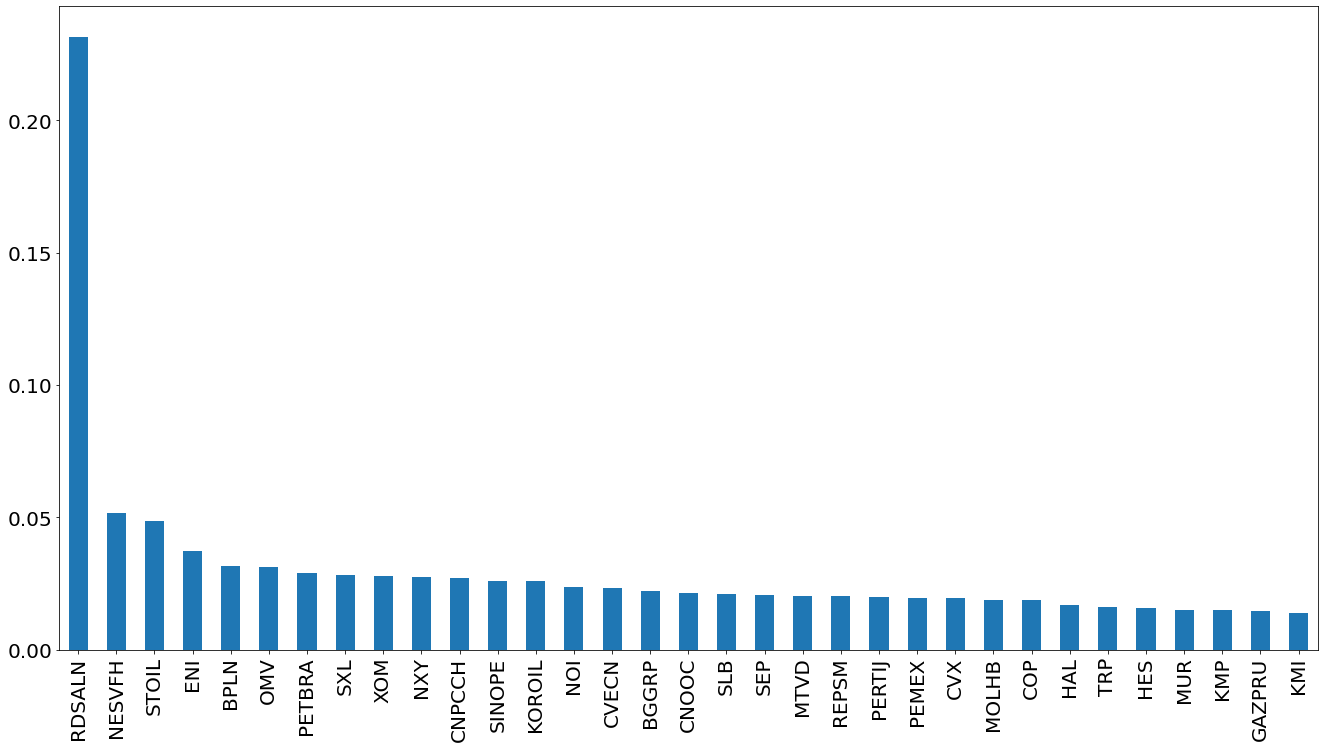

In [24]:
# FEATURE IMPORTANCE IN GLOBAL MODEL

importances = xgb_complete.feature_importances_
feature_names = class_input[regressors_complete].columns
importances = pd.Series(importances, index=feature_names).\
    sort_values(ascending=False).head(40)

fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
fig.set_size_inches(18.5,10.5)
ax.tick_params(axis='both', which='major', labelsize=20)
fig.tight_layout()

# plt.savefig('feature_importance_global_TOTAL.png', facecolor='white')

In [25]:
# FEATURE IMPORTANCE IN LOCAL MODEL

importances = xgb_local.feature_importances_
feature_names = class_input[regressors_local].columns
importances = pd.Series(importances, index=feature_names).\
    sort_values(ascending=False).head(40)

fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
fig.set_size_inches(18.5,10.5)
ax.tick_params(axis='both', which='major', labelsize=20)
fig.tight_layout()

# plt.savefig('feature_importance_local_TOTAL.png', facecolor='white')

In [28]:
print('COMPLETE MODEL')
print(confusion_matrix(y_test, pred_complete))
print(classification_report(y_test, pred_complete))
print('Accuracy: ' + str(accuracy_score(y_test, pred_complete)))
print('Precision: ' + str(precision_score(y_test, pred_complete)))
print('Recall: ' + str(recall_score(y_test, pred_complete)))
print('F1: ' + str(f1_score(y_test, pred_complete)))

COMPLETE MODEL
[[95 11]
 [10 53]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       106
           1       0.83      0.84      0.83        63

    accuracy                           0.88       169
   macro avg       0.87      0.87      0.87       169
weighted avg       0.88      0.88      0.88       169

Accuracy: 0.8757396449704142
Precision: 0.828125
Recall: 0.8412698412698413
F1: 0.8346456692913385


In [29]:
print('LOCAL MODEL')
print(confusion_matrix(y_test, pred_local))
print(classification_report(y_test, pred_local))
print('Accuracy: ' + str(accuracy_score(y_test, pred_local)))
print('Precision: ' + str(precision_score(y_test, pred_local)))
print('Recall: ' + str(recall_score(y_test, pred_local)))
print('F1: ' + str(f1_score(y_test, pred_local)))

LOCAL MODEL
[[87 19]
 [ 9 54]]
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       106
           1       0.74      0.86      0.79        63

    accuracy                           0.83       169
   macro avg       0.82      0.84      0.83       169
weighted avg       0.84      0.83      0.84       169

Accuracy: 0.834319526627219
Precision: 0.7397260273972602
Recall: 0.8571428571428571
F1: 0.7941176470588235
